In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
from scipy.special import comb

In [3]:
# Parameters
dx = 784  # MNIST dataset feature dimension
dy = 10   # MNIST dataset label dimension (after one-hot)
l = 128  # Number of random samples to mix
n = 6000 # Number of samples in the dataset
num_synthetic_samples_per_class = 1200  # 1200 synthetic samples for each digit
T = 10*num_synthetic_samples_per_class # Number of synthetic data points to generate
delta = 1 / n  # Privacy budget parameter
sigma_x_values = np.linspace(0.2, 3.0, 29)  # Sigma_x values to iterate over
sigma_y_values = sigma_x_values

epochs = 2  # number of epochs
learning_rate = 0.0001  # CNN learning rate
validation_split_ratio = 0.2

In [4]:
# Load MNIST dataset from CSV
train_data = pd.read_csv('mnist_train.csv')
x_train = train_data.iloc[:, 1:].values.astype(np.float32)  # Features
y_train = train_data.iloc[:, 0].values.astype(np.int32)  # Labels

test_data = pd.read_csv('mnist_test.csv')
x_test = test_data.iloc[:, 1:].values.astype(np.float32)  # Features
y_test = test_data.iloc[:, 0].values.astype(np.int32)  # Labels

In [5]:
# One-hot encoding
y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

In [6]:
# Reshape the data for CNN
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0

In [7]:
# Display original images for each digit
def display_original_images(X, y):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    for digit in range(10):
        ax = axes[digit]
        ax.imshow(X[y == digit][0].reshape(28, 28), cmap='gray')
        ax.set_title(f'Org {digit}')
        ax.axis('off')
    plt.show()

# Display synthetic images for each digit
def display_synthetic_images(X_synth, y_synth):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))    
    # For each digit (0-9), randomly select one image from the synthetic dataset
    for digit in range(10):
        ax = axes[digit]        
        # Get indices of images that have the current label 'digit'
        digit_indices = np.where(y_synth == digit)[0]        
        # Randomly select one image from these indices
        random_idx = np.random.choice(digit_indices)        
        # Display the randomly selected image
        ax.imshow(X_synth[random_idx].reshape(28, 28), cmap='gray')
        ax.set_title(f'Syn {digit}')
        ax.axis('off')    
    plt.show()

In [8]:
# Define the CNN model
def cnn_model():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (5, 5), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = layers.Conv2D(48, (5, 5), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# Generate 10 synthetic datasets using the DPMix algorithm
def generate_10_synthetic_datasets(X, y, sigma_x, sigma_y, l, num_samples_per_class):
    num_classes = 10
    datasets = []  # List to store the 10 synthetic datasets

    for dataset_idx in range(10):  # Loop to generate 10 datasets
        X_synthetic = []
        y_synthetic = []

        for digit in range(num_classes):
            class_indices = np.where(y == digit)[0]
            sampled_indices = np.random.choice(class_indices, l, replace=False)
            X_class = X[sampled_indices]

            original_label = np.eye(num_classes)[digit]  # One-hot encoding of the digit

            for _ in range(num_samples_per_class):
                weights = np.ones(l) / l  # Equal weights of 1/l for each sample
                mixed_sample = np.tensordot(weights, X_class, axes=1)
                noise_x = np.random.normal(0, sigma_x, mixed_sample.shape)
                noisy_sample = mixed_sample + noise_x

                noise_y = np.random.normal(0, sigma_y, original_label.shape)  # Gaussian noise for labels
                noisy_label = original_label + noise_y

                # Reverse one-hot encoding: label is the index of the max value
                label_from_noisy = np.argmax(noisy_label)

                X_synthetic.append(noisy_sample)
                y_synthetic.append(label_from_noisy)

        X_synthetic = np.array(X_synthetic)
        y_synthetic = np.array(y_synthetic)

        # Ensure no negative values in synthetic images and scale within [0, 1]
        X_synthetic[X_synthetic < 0] = 0  # Setting all negative values to 0
        #scaler_synthetic = MinMaxScaler()
        #X_synthetic = scaler_synthetic.fit_transform(X_synthetic.reshape(-1, 28 * 28))  # Reshape for scaling
        X_synthetic = X_synthetic.reshape(-1, 28, 28, 1)  # Reshape back to image format

        # Append the synthetic dataset to the list
        datasets.append((X_synthetic, y_synthetic))

    return datasets  # Return a list of 10 synthetic datasets


In [10]:
# Initialize lists for accuracies
synthetic_accuracies = []
test_accuracies = []

Displaying original images from MNIST dataset


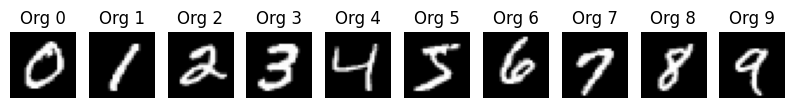

Generating 10 synthetic datasets for sigma_x = 0.2 and sigma_y = 0.2
Displaying synthetic images for sigma_x = 0.2, sigma_y = 0.2, dataset 1


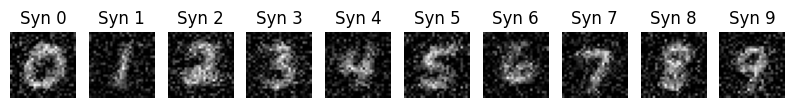

Training model on synthetic dataset 1 for sigma_x = 0.2 and sigma_y = 0.2
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4863 - loss: 1.7272 - val_accuracy: 0.9983 - val_loss: 0.0511
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9983 - loss: 0.0390 - val_accuracy: 0.9983 - val_loss: 0.0265
Test accuracy for dataset 1: 0.7774
Training model on synthetic dataset 2 for sigma_x = 0.2 and sigma_y = 0.2
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5779 - loss: 1.7303 - val_accuracy: 0.9992 - val_loss: 0.0425
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9985 - loss: 0.0461 - val_accuracy: 0.9992 - val_loss: 0.0160
Test accuracy for dataset 2: 0.7816
Training model on synthetic dataset 3 for sigma_x = 0.2 and sigma_y = 0.2
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5976 - loss: 1.7323 - val_accuracy: 0.9987 - val_loss: 0.0582
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9985 -

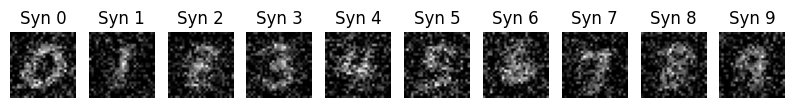

Training model on synthetic dataset 1 for sigma_x = 0.3 and sigma_y = 0.3
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4670 - loss: 1.9065 - val_accuracy: 0.9421 - val_loss: 0.4759
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9403 - loss: 0.4615 - val_accuracy: 0.9404 - val_loss: 0.4126
Test accuracy for dataset 1: 0.7868
Training model on synthetic dataset 2 for sigma_x = 0.3 and sigma_y = 0.3
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4137 - loss: 1.8693 - val_accuracy: 0.9496 - val_loss: 0.4419
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9442 - loss: 0.4459 - val_accuracy: 0.9496 - val_loss: 0.3778
Test accuracy for dataset 2: 0.7801
Training model on synthetic dataset 3 for sigma_x = 0.3 and sigma_y = 0.3
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5196 - loss: 1.8976 - val_accuracy: 0.9425 - val_loss: 0.4562
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9420 -

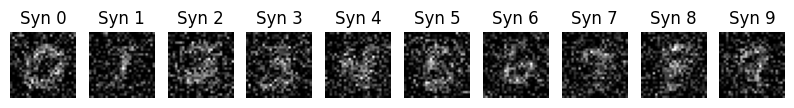

Training model on synthetic dataset 1 for sigma_x = 0.4 and sigma_y = 0.4
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3803 - loss: 2.0290 - val_accuracy: 0.7921 - val_loss: 1.1469
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8075 - loss: 1.0746 - val_accuracy: 0.7946 - val_loss: 1.0616
Test accuracy for dataset 1: 0.7922
Training model on synthetic dataset 2 for sigma_x = 0.4 and sigma_y = 0.4
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4191 - loss: 2.0427 - val_accuracy: 0.7721 - val_loss: 1.1763
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7995 - loss: 1.0909 - val_accuracy: 0.7954 - val_loss: 1.0571
Test accuracy for dataset 2: 0.8085
Training model on synthetic dataset 3 for sigma_x = 0.4 and sigma_y = 0.4
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3274 - loss: 2.0910 - val_accuracy: 0.7983 - val_loss: 1.1459
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7940 -

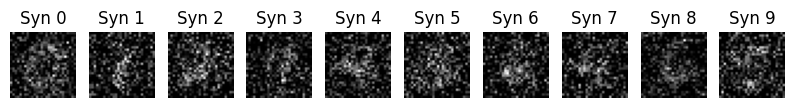

Training model on synthetic dataset 1 for sigma_x = 0.5 and sigma_y = 0.5
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2149 - loss: 2.2182 - val_accuracy: 0.6033 - val_loss: 1.6633
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6450 - loss: 1.5962 - val_accuracy: 0.6558 - val_loss: 1.5256
Test accuracy for dataset 1: 0.7825
Training model on synthetic dataset 2 for sigma_x = 0.5 and sigma_y = 0.5
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2440 - loss: 2.2134 - val_accuracy: 0.6367 - val_loss: 1.5804
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6362 - loss: 1.5980 - val_accuracy: 0.6733 - val_loss: 1.4656
Test accuracy for dataset 2: 0.7870
Training model on synthetic dataset 3 for sigma_x = 0.5 and sigma_y = 0.5
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2804 - loss: 2.1941 - val_accuracy: 0.6621 - val_loss: 1.6174
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6537 -

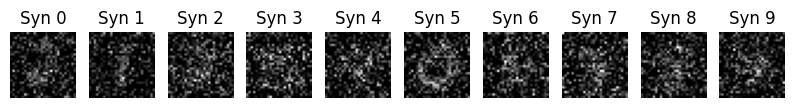

Training model on synthetic dataset 1 for sigma_x = 0.6 and sigma_y = 0.6
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1789 - loss: 2.2689 - val_accuracy: 0.4683 - val_loss: 2.0064
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4704 - loss: 1.9385 - val_accuracy: 0.5183 - val_loss: 1.8454
Test accuracy for dataset 1: 0.7308
Training model on synthetic dataset 2 for sigma_x = 0.6 and sigma_y = 0.6
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1704 - loss: 2.2709 - val_accuracy: 0.4383 - val_loss: 2.0127
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4679 - loss: 1.9379 - val_accuracy: 0.5217 - val_loss: 1.8340
Test accuracy for dataset 2: 0.7672
Training model on synthetic dataset 3 for sigma_x = 0.6 and sigma_y = 0.6
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1609 - loss: 2.2782 - val_accuracy: 0.4454 - val_loss: 2.0362
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4764 -

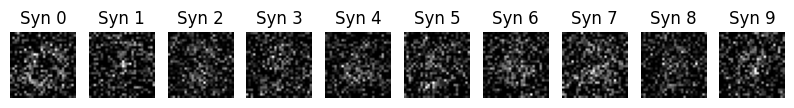

Training model on synthetic dataset 1 for sigma_x = 0.7 and sigma_y = 0.7
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1360 - loss: 2.2914 - val_accuracy: 0.3017 - val_loss: 2.1909
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3371 - loss: 2.1334 - val_accuracy: 0.3913 - val_loss: 2.0315
Test accuracy for dataset 1: 0.7424
Training model on synthetic dataset 2 for sigma_x = 0.7 and sigma_y = 0.7
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1277 - loss: 2.2988 - val_accuracy: 0.3225 - val_loss: 2.2095
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3108 - loss: 2.1638 - val_accuracy: 0.4038 - val_loss: 2.0304
Test accuracy for dataset 2: 0.7056
Training model on synthetic dataset 3 for sigma_x = 0.7 and sigma_y = 0.7
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1456 - loss: 2.2861 - val_accuracy: 0.3038 - val_loss: 2.1847
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3235 -

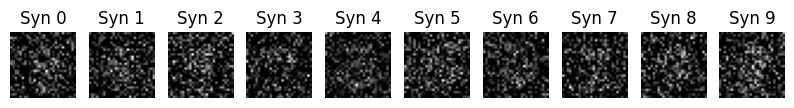

Training model on synthetic dataset 1 for sigma_x = 0.8 and sigma_y = 0.8
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1222 - loss: 2.2988 - val_accuracy: 0.1629 - val_loss: 2.2764
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2239 - loss: 2.2414 - val_accuracy: 0.2896 - val_loss: 2.1527
Test accuracy for dataset 1: 0.6372
Training model on synthetic dataset 2 for sigma_x = 0.8 and sigma_y = 0.8
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1219 - loss: 2.2985 - val_accuracy: 0.1658 - val_loss: 2.2623
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2217 - loss: 2.2295 - val_accuracy: 0.3104 - val_loss: 2.1608
Test accuracy for dataset 2: 0.6484
Training model on synthetic dataset 3 for sigma_x = 0.8 and sigma_y = 0.8
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1137 - loss: 2.3019 - val_accuracy: 0.2129 - val_loss: 2.2679
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2279 -

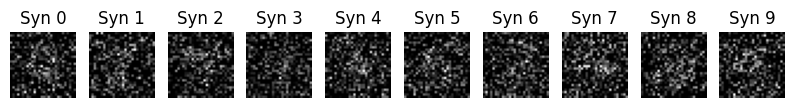

Training model on synthetic dataset 1 for sigma_x = 0.8999999999999999 and sigma_y = 0.8999999999999999
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0976 - loss: 2.3068 - val_accuracy: 0.1008 - val_loss: 2.3064
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1392 - loss: 2.2892 - val_accuracy: 0.1933 - val_loss: 2.2669
Test accuracy for dataset 1: 0.4951
Training model on synthetic dataset 2 for sigma_x = 0.8999999999999999 and sigma_y = 0.8999999999999999
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1095 - loss: 2.3009 - val_accuracy: 0.1375 - val_loss: 2.2886
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1602 - loss: 2.2747 - val_accuracy: 0.2013 - val_loss: 2.2398
Test accuracy for dataset 2: 0.6272
Training model on synthetic dataset 3 for sigma_x = 0.8999999999999999 and sigma_y = 0.8999999999999999
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1058 - loss: 2.3042 - val_accuracy: 0.1242 

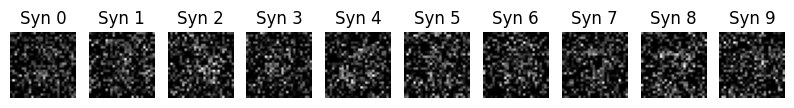

Training model on synthetic dataset 1 for sigma_x = 1.0 and sigma_y = 1.0
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1120 - loss: 2.3062 - val_accuracy: 0.1004 - val_loss: 2.2992
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1408 - loss: 2.2887 - val_accuracy: 0.1725 - val_loss: 2.2712
Test accuracy for dataset 1: 0.4447
Training model on synthetic dataset 2 for sigma_x = 1.0 and sigma_y = 1.0
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1025 - loss: 2.3046 - val_accuracy: 0.1412 - val_loss: 2.2934
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1656 - loss: 2.2825 - val_accuracy: 0.1842 - val_loss: 2.2607
Test accuracy for dataset 2: 0.5152
Training model on synthetic dataset 3 for sigma_x = 1.0 and sigma_y = 1.0
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1115 - loss: 2.3028 - val_accuracy: 0.1304 - val_loss: 2.2932
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1480 -

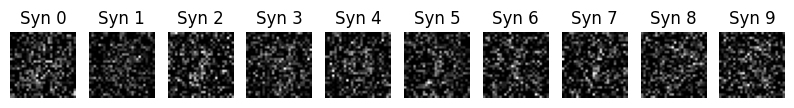

Training model on synthetic dataset 1 for sigma_x = 1.0999999999999999 and sigma_y = 1.0999999999999999
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1057 - loss: 2.3070 - val_accuracy: 0.1196 - val_loss: 2.3018
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1320 - loss: 2.2936 - val_accuracy: 0.1663 - val_loss: 2.2847
Test accuracy for dataset 1: 0.4549
Training model on synthetic dataset 2 for sigma_x = 1.0999999999999999 and sigma_y = 1.0999999999999999
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0977 - loss: 2.3080 - val_accuracy: 0.1008 - val_loss: 2.3018
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1183 - loss: 2.2980 - val_accuracy: 0.1121 - val_loss: 2.2979
Test accuracy for dataset 2: 0.3995
Training model on synthetic dataset 3 for sigma_x = 1.0999999999999999 and sigma_y = 1.0999999999999999
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1039 - loss: 2.3060 - val_accuracy: 0.1175 

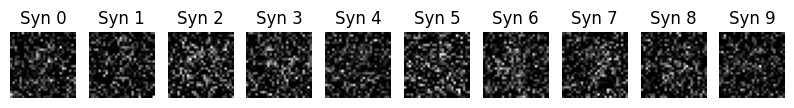

Training model on synthetic dataset 1 for sigma_x = 1.2 and sigma_y = 1.2
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0960 - loss: 2.3078 - val_accuracy: 0.1138 - val_loss: 2.3039
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1205 - loss: 2.2987 - val_accuracy: 0.1183 - val_loss: 2.2998
Test accuracy for dataset 1: 0.3600
Training model on synthetic dataset 2 for sigma_x = 1.2 and sigma_y = 1.2
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1014 - loss: 2.3073 - val_accuracy: 0.0962 - val_loss: 2.3027
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1136 - loss: 2.2982 - val_accuracy: 0.1158 - val_loss: 2.3006
Test accuracy for dataset 2: 0.4213
Training model on synthetic dataset 3 for sigma_x = 1.2 and sigma_y = 1.2
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1017 - loss: 2.3064 - val_accuracy: 0.1112 - val_loss: 2.3019
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1234 -

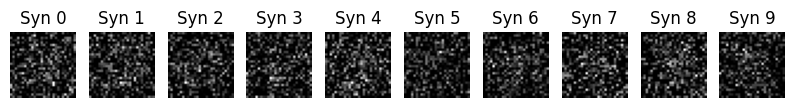

Training model on synthetic dataset 1 for sigma_x = 1.2999999999999998 and sigma_y = 1.2999999999999998
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0974 - loss: 2.3098 - val_accuracy: 0.1133 - val_loss: 2.3034
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1224 - loss: 2.2971 - val_accuracy: 0.1287 - val_loss: 2.2965
Test accuracy for dataset 1: 0.4014
Training model on synthetic dataset 2 for sigma_x = 1.2999999999999998 and sigma_y = 1.2999999999999998
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0979 - loss: 2.3094 - val_accuracy: 0.1013 - val_loss: 2.3033
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1199 - loss: 2.2980 - val_accuracy: 0.1033 - val_loss: 2.3007
Test accuracy for dataset 2: 0.3695
Training model on synthetic dataset 3 for sigma_x = 1.2999999999999998 and sigma_y = 1.2999999999999998
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0975 - loss: 2.3105 - val_accuracy: 0.1088 

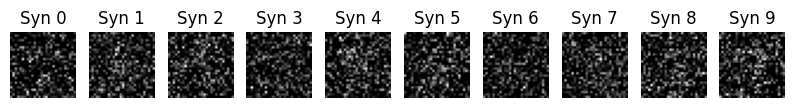

Training model on synthetic dataset 1 for sigma_x = 1.4 and sigma_y = 1.4
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1021 - loss: 2.3106 - val_accuracy: 0.1104 - val_loss: 2.3052
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1150 - loss: 2.3012 - val_accuracy: 0.1083 - val_loss: 2.3022
Test accuracy for dataset 1: 0.2648
Training model on synthetic dataset 2 for sigma_x = 1.4 and sigma_y = 1.4
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1032 - loss: 2.3096 - val_accuracy: 0.1138 - val_loss: 2.3018
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1105 - loss: 2.3007 - val_accuracy: 0.1175 - val_loss: 2.2995
Test accuracy for dataset 2: 0.2529
Training model on synthetic dataset 3 for sigma_x = 1.4 and sigma_y = 1.4
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1091 - loss: 2.3093 - val_accuracy: 0.1029 - val_loss: 2.3050
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1061 -

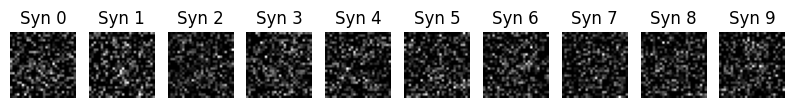

Training model on synthetic dataset 1 for sigma_x = 1.4999999999999998 and sigma_y = 1.4999999999999998
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1040 - loss: 2.3106 - val_accuracy: 0.1029 - val_loss: 2.3026
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1109 - loss: 2.3016 - val_accuracy: 0.1046 - val_loss: 2.3052
Test accuracy for dataset 1: 0.1537
Training model on synthetic dataset 2 for sigma_x = 1.4999999999999998 and sigma_y = 1.4999999999999998
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1076 - loss: 2.3095 - val_accuracy: 0.0962 - val_loss: 2.3025
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1063 - loss: 2.3012 - val_accuracy: 0.1096 - val_loss: 2.3054
Test accuracy for dataset 2: 0.1634
Training model on synthetic dataset 3 for sigma_x = 1.4999999999999998 and sigma_y = 1.4999999999999998
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1082 - loss: 2.3078 - val_accuracy: 0.1133 

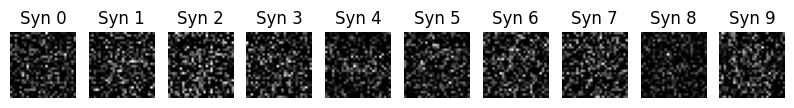

Training model on synthetic dataset 1 for sigma_x = 1.5999999999999999 and sigma_y = 1.5999999999999999
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1071 - loss: 2.3082 - val_accuracy: 0.1017 - val_loss: 2.3046
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1088 - loss: 2.3022 - val_accuracy: 0.1025 - val_loss: 2.3036
Test accuracy for dataset 1: 0.1990
Training model on synthetic dataset 2 for sigma_x = 1.5999999999999999 and sigma_y = 1.5999999999999999
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0907 - loss: 2.3115 - val_accuracy: 0.1017 - val_loss: 2.3108
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1086 - loss: 2.3024 - val_accuracy: 0.0983 - val_loss: 2.3049
Test accuracy for dataset 2: 0.1753
Training model on synthetic dataset 3 for sigma_x = 1.5999999999999999 and sigma_y = 1.5999999999999999
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0996 - loss: 2.3084 - val_accuracy: 0.1063 

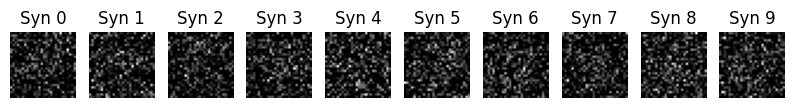

Training model on synthetic dataset 1 for sigma_x = 1.6999999999999997 and sigma_y = 1.6999999999999997
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1039 - loss: 2.3089 - val_accuracy: 0.1063 - val_loss: 2.3013
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1092 - loss: 2.3003 - val_accuracy: 0.1092 - val_loss: 2.3026
Test accuracy for dataset 1: 0.1429
Training model on synthetic dataset 2 for sigma_x = 1.6999999999999997 and sigma_y = 1.6999999999999997
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0969 - loss: 2.3133 - val_accuracy: 0.0992 - val_loss: 2.3029
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1130 - loss: 2.3000 - val_accuracy: 0.0971 - val_loss: 2.3030
Test accuracy for dataset 2: 0.1108
Training model on synthetic dataset 3 for sigma_x = 1.6999999999999997 and sigma_y = 1.6999999999999997
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0994 - loss: 2.3124 - val_accuracy: 0.1046 

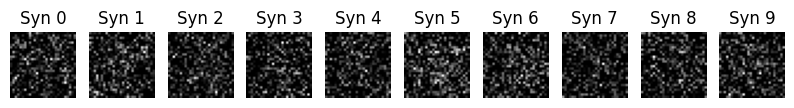

Training model on synthetic dataset 1 for sigma_x = 1.7999999999999998 and sigma_y = 1.7999999999999998
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1066 - loss: 2.3115 - val_accuracy: 0.1133 - val_loss: 2.3026
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1052 - loss: 2.3015 - val_accuracy: 0.0929 - val_loss: 2.3080
Test accuracy for dataset 1: 0.1208
Training model on synthetic dataset 2 for sigma_x = 1.7999999999999998 and sigma_y = 1.7999999999999998
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0993 - loss: 2.3074 - val_accuracy: 0.1042 - val_loss: 2.3037
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1014 - loss: 2.3021 - val_accuracy: 0.0983 - val_loss: 2.3036
Test accuracy for dataset 2: 0.1580
Training model on synthetic dataset 3 for sigma_x = 1.7999999999999998 and sigma_y = 1.7999999999999998
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1139 - loss: 2.3066 - val_accuracy: 0.1017 

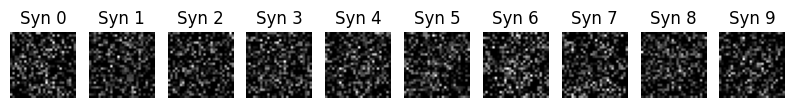

Training model on synthetic dataset 1 for sigma_x = 1.9 and sigma_y = 1.9
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1047 - loss: 2.3102 - val_accuracy: 0.0958 - val_loss: 2.3032
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1158 - loss: 2.2999 - val_accuracy: 0.1075 - val_loss: 2.3015
Test accuracy for dataset 1: 0.2410
Training model on synthetic dataset 2 for sigma_x = 1.9 and sigma_y = 1.9
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1019 - loss: 2.3138 - val_accuracy: 0.0979 - val_loss: 2.3073
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1089 - loss: 2.3010 - val_accuracy: 0.0954 - val_loss: 2.3080
Test accuracy for dataset 2: 0.1128
Training model on synthetic dataset 3 for sigma_x = 1.9 and sigma_y = 1.9
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1065 - loss: 2.3084 - val_accuracy: 0.0962 - val_loss: 2.3061
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1120 -

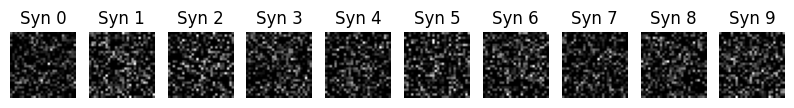

Training model on synthetic dataset 1 for sigma_x = 1.9999999999999998 and sigma_y = 1.9999999999999998
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1036 - loss: 2.3115 - val_accuracy: 0.0967 - val_loss: 2.3125
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1032 - loss: 2.3009 - val_accuracy: 0.1008 - val_loss: 2.3098
Test accuracy for dataset 1: 0.1668
Training model on synthetic dataset 2 for sigma_x = 1.9999999999999998 and sigma_y = 1.9999999999999998
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1032 - loss: 2.3131 - val_accuracy: 0.0992 - val_loss: 2.3090
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1100 - loss: 2.3009 - val_accuracy: 0.1017 - val_loss: 2.3060
Test accuracy for dataset 2: 0.1442
Training model on synthetic dataset 3 for sigma_x = 1.9999999999999998 and sigma_y = 1.9999999999999998
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1031 - loss: 2.3153 - val_accuracy: 0.0983 

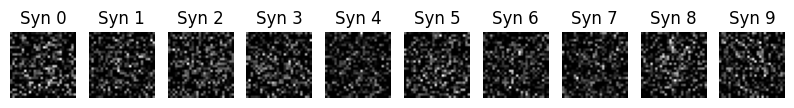

Training model on synthetic dataset 1 for sigma_x = 2.1 and sigma_y = 2.1
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1037 - loss: 2.3155 - val_accuracy: 0.0996 - val_loss: 2.3116
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1056 - loss: 2.3010 - val_accuracy: 0.1029 - val_loss: 2.3101
Test accuracy for dataset 1: 0.2169
Training model on synthetic dataset 2 for sigma_x = 2.1 and sigma_y = 2.1
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0931 - loss: 2.3151 - val_accuracy: 0.1117 - val_loss: 2.3047
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1075 - loss: 2.3034 - val_accuracy: 0.1125 - val_loss: 2.3041
Test accuracy for dataset 2: 0.1450
Training model on synthetic dataset 3 for sigma_x = 2.1 and sigma_y = 2.1
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1015 - loss: 2.3117 - val_accuracy: 0.1063 - val_loss: 2.3067
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1109 -

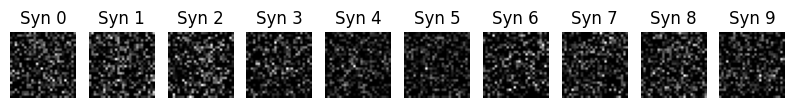

Training model on synthetic dataset 1 for sigma_x = 2.1999999999999997 and sigma_y = 2.1999999999999997
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1007 - loss: 2.3145 - val_accuracy: 0.1100 - val_loss: 2.3068
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1131 - loss: 2.3046 - val_accuracy: 0.1083 - val_loss: 2.3065
Test accuracy for dataset 1: 0.0597
Training model on synthetic dataset 2 for sigma_x = 2.1999999999999997 and sigma_y = 2.1999999999999997
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0937 - loss: 2.3189 - val_accuracy: 0.1046 - val_loss: 2.3069
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1068 - loss: 2.3019 - val_accuracy: 0.0942 - val_loss: 2.3093
Test accuracy for dataset 2: 0.1639
Training model on synthetic dataset 3 for sigma_x = 2.1999999999999997 and sigma_y = 2.1999999999999997
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0923 - loss: 2.3140 - val_accuracy: 0.1033 

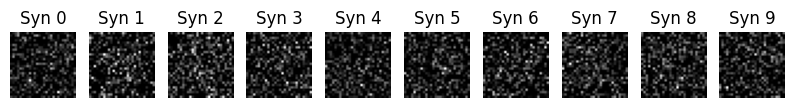

Training model on synthetic dataset 1 for sigma_x = 2.3 and sigma_y = 2.3
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1042 - loss: 2.3170 - val_accuracy: 0.0942 - val_loss: 2.3065
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1157 - loss: 2.3002 - val_accuracy: 0.0938 - val_loss: 2.3060
Test accuracy for dataset 1: 0.1592
Training model on synthetic dataset 2 for sigma_x = 2.3 and sigma_y = 2.3
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0956 - loss: 2.3116 - val_accuracy: 0.0954 - val_loss: 2.3055
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1181 - loss: 2.3004 - val_accuracy: 0.0946 - val_loss: 2.3089
Test accuracy for dataset 2: 0.1504
Training model on synthetic dataset 3 for sigma_x = 2.3 and sigma_y = 2.3
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1106 - loss: 2.3097 - val_accuracy: 0.1000 - val_loss: 2.3037
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1082 -

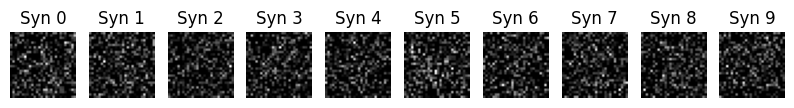

Training model on synthetic dataset 1 for sigma_x = 2.4 and sigma_y = 2.4
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1044 - loss: 2.3215 - val_accuracy: 0.1000 - val_loss: 2.3066
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1051 - loss: 2.3017 - val_accuracy: 0.1088 - val_loss: 2.3065
Test accuracy for dataset 1: 0.1053
Training model on synthetic dataset 2 for sigma_x = 2.4 and sigma_y = 2.4
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0893 - loss: 2.3168 - val_accuracy: 0.1054 - val_loss: 2.3059
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1033 - loss: 2.3039 - val_accuracy: 0.1025 - val_loss: 2.3059
Test accuracy for dataset 2: 0.0992
Training model on synthetic dataset 3 for sigma_x = 2.4 and sigma_y = 2.4
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0973 - loss: 2.3093 - val_accuracy: 0.1079 - val_loss: 2.3033
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1145 -

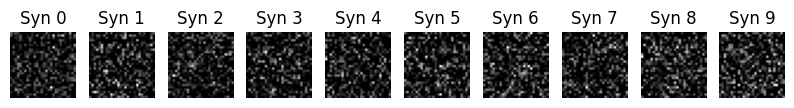

Training model on synthetic dataset 1 for sigma_x = 2.5 and sigma_y = 2.5
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0975 - loss: 2.3161 - val_accuracy: 0.1042 - val_loss: 2.3057
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1091 - loss: 2.3024 - val_accuracy: 0.1058 - val_loss: 2.3041
Test accuracy for dataset 1: 0.1106
Training model on synthetic dataset 2 for sigma_x = 2.5 and sigma_y = 2.5
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0947 - loss: 2.3167 - val_accuracy: 0.0979 - val_loss: 2.3061
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1088 - loss: 2.3020 - val_accuracy: 0.0921 - val_loss: 2.3083
Test accuracy for dataset 2: 0.1662
Training model on synthetic dataset 3 for sigma_x = 2.5 and sigma_y = 2.5
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1001 - loss: 2.3167 - val_accuracy: 0.0988 - val_loss: 2.3094
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1089 -

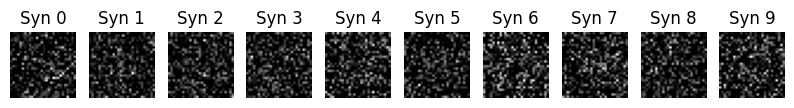

Training model on synthetic dataset 1 for sigma_x = 2.6 and sigma_y = 2.6
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0919 - loss: 2.3290 - val_accuracy: 0.1000 - val_loss: 2.3033
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1056 - loss: 2.3014 - val_accuracy: 0.1029 - val_loss: 2.3039
Test accuracy for dataset 1: 0.1320
Training model on synthetic dataset 2 for sigma_x = 2.6 and sigma_y = 2.6
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0973 - loss: 2.3224 - val_accuracy: 0.0988 - val_loss: 2.3056
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1044 - loss: 2.3030 - val_accuracy: 0.0892 - val_loss: 2.3082
Test accuracy for dataset 2: 0.1728
Training model on synthetic dataset 3 for sigma_x = 2.6 and sigma_y = 2.6
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1001 - loss: 2.3258 - val_accuracy: 0.0971 - val_loss: 2.3121
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1130 -

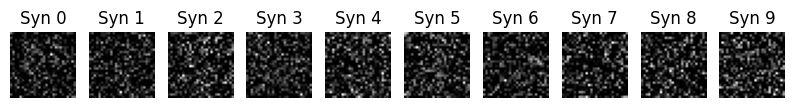

Training model on synthetic dataset 1 for sigma_x = 2.7 and sigma_y = 2.7
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1039 - loss: 2.3179 - val_accuracy: 0.1017 - val_loss: 2.3098
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1153 - loss: 2.3010 - val_accuracy: 0.1008 - val_loss: 2.3050
Test accuracy for dataset 1: 0.1097
Training model on synthetic dataset 2 for sigma_x = 2.7 and sigma_y = 2.7
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1009 - loss: 2.3182 - val_accuracy: 0.0992 - val_loss: 2.3074
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1148 - loss: 2.3023 - val_accuracy: 0.0962 - val_loss: 2.3069
Test accuracy for dataset 2: 0.0903
Training model on synthetic dataset 3 for sigma_x = 2.7 and sigma_y = 2.7
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0991 - loss: 2.3115 - val_accuracy: 0.0950 - val_loss: 2.3063
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1074 -

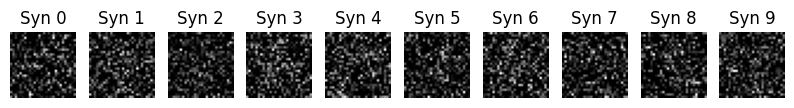

Training model on synthetic dataset 1 for sigma_x = 2.8 and sigma_y = 2.8
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1016 - loss: 2.3186 - val_accuracy: 0.1033 - val_loss: 2.3050
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1074 - loss: 2.3015 - val_accuracy: 0.0988 - val_loss: 2.3031
Test accuracy for dataset 1: 0.1409
Training model on synthetic dataset 2 for sigma_x = 2.8 and sigma_y = 2.8
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1019 - loss: 2.3103 - val_accuracy: 0.1017 - val_loss: 2.3072
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1176 - loss: 2.3006 - val_accuracy: 0.1042 - val_loss: 2.3037
Test accuracy for dataset 2: 0.1134
Training model on synthetic dataset 3 for sigma_x = 2.8 and sigma_y = 2.8
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1036 - loss: 2.3144 - val_accuracy: 0.0996 - val_loss: 2.3060
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1066 -

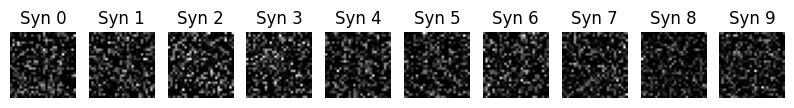

Training model on synthetic dataset 1 for sigma_x = 2.9 and sigma_y = 2.9
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1024 - loss: 2.3172 - val_accuracy: 0.1000 - val_loss: 2.3034
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1081 - loss: 2.3003 - val_accuracy: 0.1037 - val_loss: 2.3060
Test accuracy for dataset 1: 0.1015
Training model on synthetic dataset 2 for sigma_x = 2.9 and sigma_y = 2.9
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1049 - loss: 2.3178 - val_accuracy: 0.1100 - val_loss: 2.3064
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1115 - loss: 2.3023 - val_accuracy: 0.0996 - val_loss: 2.3045
Test accuracy for dataset 2: 0.0721
Training model on synthetic dataset 3 for sigma_x = 2.9 and sigma_y = 2.9
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1037 - loss: 2.3093 - val_accuracy: 0.0929 - val_loss: 2.3133
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1127 -

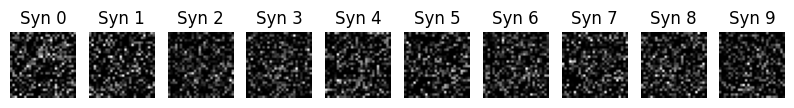

Training model on synthetic dataset 1 for sigma_x = 3.0 and sigma_y = 3.0
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1042 - loss: 2.3155 - val_accuracy: 0.1008 - val_loss: 2.3116
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1134 - loss: 2.3011 - val_accuracy: 0.0996 - val_loss: 2.3059
Test accuracy for dataset 1: 0.0920
Training model on synthetic dataset 2 for sigma_x = 3.0 and sigma_y = 3.0
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1046 - loss: 2.3162 - val_accuracy: 0.0958 - val_loss: 2.3133
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1088 - loss: 2.3012 - val_accuracy: 0.1013 - val_loss: 2.3075
Test accuracy for dataset 2: 0.1527
Training model on synthetic dataset 3 for sigma_x = 3.0 and sigma_y = 3.0
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1070 - loss: 2.3138 - val_accuracy: 0.0950 - val_loss: 2.3068
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1071 -

In [11]:
# Display original images once
print(f"Displaying original images from MNIST dataset")
display_original_images(x_train, y_train)

# Initialize an empty list to store average accuracies
average_accuracies = []

# Loop over sigma_x, sigma_y values
for sigma_x, sigma_y in zip(sigma_x_values, sigma_y_values):         
    print(f"Generating 10 synthetic datasets for sigma_x = {sigma_x} and sigma_y = {sigma_y}")
    
    # Generate 10 synthetic datasets for current sigma_x and sigma_y
    synthetic_datasets = generate_10_synthetic_datasets(x_train, y_train, sigma_x, sigma_y, l, num_synthetic_samples_per_class)

    # Initialize a list to store test accuracies for this (sigma_x, sigma_y)
    test_accuracies_per_sigma = []

    for dataset_idx, (x_synthetic, y_synthetic) in enumerate(synthetic_datasets):
        # Display synthetic images for the first dataset
        if dataset_idx == 0:
            print(f"Displaying synthetic images for sigma_x = {sigma_x}, sigma_y = {sigma_y}, dataset {dataset_idx + 1}")
            display_synthetic_images(x_synthetic, y_synthetic)
        
        # One-hot encode synthetic labels
        y_synthetic_one_hot = np.eye(10)[y_synthetic]

        # Split synthetic data into training and validation sets
        x_synth_train, x_synth_val, y_synth_train, y_synth_val = train_test_split(
            x_synthetic, y_synthetic_one_hot, test_size=validation_split_ratio)

        print(f"Training model on synthetic dataset {dataset_idx + 1} for sigma_x = {sigma_x} and sigma_y = {sigma_y}")

        # Build the CNN model
        model = cnn_model()

        # Add callbacks for early stopping and model checkpointing
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(
            f'best_modelnsU_sigma_{sigma_x}_{sigma_y}_dataset_{dataset_idx + 1}.keras',
            save_best_only=True, monitor='val_accuracy', mode='max')

        # Train the model with train/validation split
        model.fit(
            x_synth_train, y_synth_train,
            validation_data=(x_synth_val, y_synth_val),
            epochs=epochs, callbacks=[early_stopping, model_checkpoint], verbose=1)

        # Evaluate on original MNIST test dataset
        test_loss, test_acc = model.evaluate(x_test, y_test_one_hot, verbose=0)
        print(f"Test accuracy for dataset {dataset_idx + 1}: {test_acc:.4f}")
        test_accuracies_per_sigma.append(test_acc)

    # Compute and store average accuracy for the current sigma_x and sigma_y
    avg_accuracy = np.mean(test_accuracies_per_sigma)
    print(f"Average test accuracy for sigma_x = {sigma_x}, sigma_y = {sigma_y}: {avg_accuracy:.4f}")
    average_accuracies.append(avg_accuracy)



In [12]:
# Polynomial Regression
#coefficients = np.polyfit(sigma_x_values, average_accuracies, deg=7)
#poly_fit = np.poly1d(coefficients)
#smoothed_accuracy = poly_fit(sigma_x_values)

In [13]:
# Savitzky-Golay Filter
#from scipy.signal import savgol_filter
#smooth_accuracy_filter = savgol_filter(average_accuracies, window_length=3, polyorder=0)

In [14]:
# Calculate the values of epsilon
epsilon_values = []  # To store epsilon values for each sigma_x

# Bernoulli polynomial B(l) calculation
def B(l, Delta2):
    sum_B = 0
    for i in range(l + 1):
        sum_B += (-1)**i * comb(l, i) * np.exp(i * (i - 1) * Delta2 / (2 * l**2))
    return sum_B

# G(alpha) calculation
def G(alpha, l, n, Delta2):
    sum_G = 0
    for j in range(3, alpha + 1):
        sum_G += (l / n)**j * comb(alpha, j) * math.sqrt(B(2 * (j // 2), Delta2) * B(2 * (j - j // 2), Delta2))
    return sum_G

# εα' calculation
def epsilon_alpha_prime(alpha, l, n, Delta2):
    min_term = min(4 * (np.exp(Delta2 / l**2) - 1), 2 * np.exp(Delta2 / l**2))
    term1 = (l / n)**2 * comb(alpha, 2) * min_term
    term2 = 4 * G(alpha, l, n, Delta2)
    return (1 / (alpha - 1)) * np.log(1 + term1 + term2)

# Final ε calculation
def epsilon(T, l, n, Delta2, delta=1/n):
    epsilons = []
    for alpha in range(2, 101): # alpha varies from 2 to 100
        try:
            epsilon_alpha = epsilon_alpha_prime(alpha, l, n, Delta2)
            epsilon_total = T * epsilon_alpha + np.log(1 / delta) / (alpha - 1)
            epsilons.append(epsilon_total)
        except (OverflowError, ValueError):
            break
    return min(epsilons)

# Loop over sigma_values to calculate epsilon for each sigma_x
for sigma_x, sigma_y in zip(sigma_x_values, sigma_y_values):
    Delta2 = (dx / sigma_x**2)  +(dy / sigma_y**2)
    epsilon_value = epsilon(T, l, n, Delta2, delta)
    epsilon_values.append(epsilon_value)

C:\Users\User\AppData\Local\Temp\ipykernel_12620\1720750952.py:8: RuntimeWarning: overflow encountered in exp
  sum_B += (-1)**i * comb(l, i) * np.exp(i * (i - 1) * Delta2 / (2 * l**2))
C:\Users\User\AppData\Local\Temp\ipykernel_12620\1720750952.py:8: RuntimeWarning: invalid value encountered in scalar add
  sum_B += (-1)**i * comb(l, i) * np.exp(i * (i - 1) * Delta2 / (2 * l**2))
C:\Users\User\AppData\Local\Temp\ipykernel_12620\1720750952.py:8: RuntimeWarning: overflow encountered in scalar multiply
  sum_B += (-1)**i * comb(l, i) * np.exp(i * (i - 1) * Delta2 / (2 * l**2))
C:\Users\User\AppData\Local\Temp\ipykernel_12620\1720750952.py:15: RuntimeWarning: overflow encountered in scalar multiply
  sum_G += (l / n)**j * comb(alpha, j) * math.sqrt(B(2 * (j // 2), Delta2) * B(2 * (j - j // 2), Delta2))


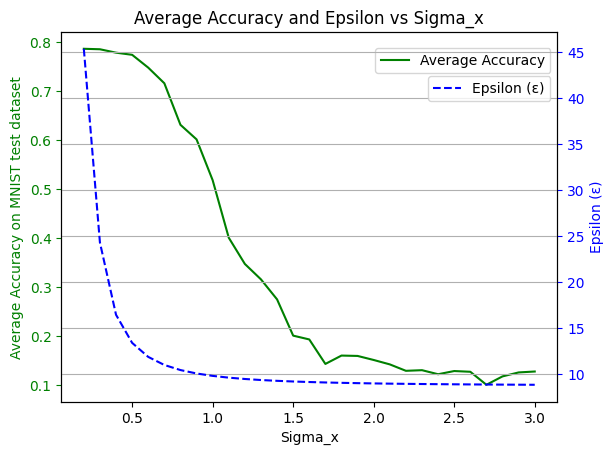

In [15]:
# Plot average accuracy vs sigma_x vs epsilon
fig, ax1 = plt.subplots()

# Plot average accuracy
ax1.plot(sigma_x_values, average_accuracies, 'g', label='Average Accuracy')
#ax1.plot(sigma_x_values, smoothed_accuracy, 'r', label='Average Accuracy (Polynomial Regresion)')
#ax1.plot(sigma_x_values, smooth_accuracy_filter, 'm', label='Average Accuracy (Savitzky-Golay Filter)')
ax1.set_xlabel('Sigma_x')
ax1.set_ylabel('Average Accuracy on MNIST test dataset', color='g')
ax1.tick_params('y', colors='g')

# Plot epsilon on a secondary Y-axis
ax2 = ax1.twinx()
ax2.plot(sigma_x_values, epsilon_values, 'b--', label='Epsilon (ε)')
ax2.set_ylabel('Epsilon (ε)', color='b')
ax2.tick_params('y', colors='b')

# Collect handles and labels from both axes
#handles1, labels1 = ax1.get_legend_handles_labels()
#handles2, labels2 = ax2.get_legend_handles_labels()
# Create a single legend using the combined handles and labels
#fig.legend(handles1 + handles2, labels1 + labels2, loc='upper right', bbox_to_anchor=(1, 0.9))

# Add title and grid
plt.title('Average Accuracy and Epsilon vs Sigma_x')
ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.975))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.90))
plt.grid(True)
plt.show()